In [1]:
# [RDKitで化学反応：ケモインフォマティクスにおける反応式の扱い方 | 化学の新しいカタチ](https://future-chem.com/rdkit-chemical-rxn/)
# https://future-chem.com/rdkit-chemical-rxn/

In [42]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import numpy as np

In [4]:
rxn = AllChem.ReactionFromRxnFile('./training-rxn-file/amideReaction.rxn')
print(type(rxn))
rxn.GetNumReactantTemplates(), rxn.GetNumProductTemplates()

<class 'rdkit.Chem.rdChemReactions.ChemicalReaction'>


(2, 2)

In [19]:
# execute reaction by Reaction Object
benzoic_acid = Chem.MolFromSmiles('c1ccccc1C(=O)O')
benzylamine = Chem.MolFromSmiles('c1ccccc1CN')
smarts = '[C:1](=[O:2])O.[N!0H:3][C:4]>>[C:1](=[O:2])[N!0H:3][C:4]'
# smarts = 'smarts = [C:1](=[O:2])O.[N!0H:3][C:4]>>[C:1](=[O:2])[N!0H:3][C:4]'


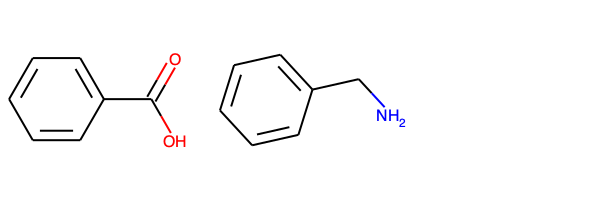

In [38]:
# Draw.MolToImage(benzoic_acid)
# Draw.MolToImage(benzylamine)
Draw.MolsToGridImage([benzoic_acid, benzylamine])

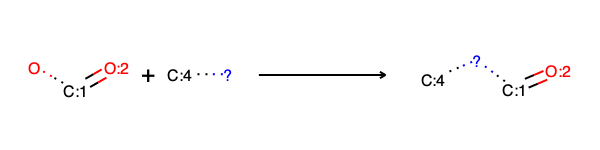

In [21]:
rxn3 = AllChem.ReactionFromSmarts(smarts)
rxn3

1


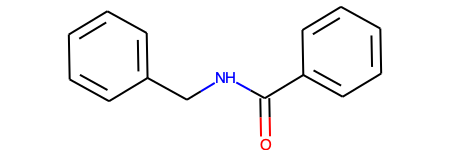

In [28]:
x = rxn3.RunReactants([benzoic_acid, benzylamine])
print(len(x))
p = x[0][0]
p

In [39]:
# Suzuki-Miyaura Cross Coupling Reaction
suppl1 = Chem.SDMolSupplier('./sdf/ArBr.sdf')
ArBr = [x for x in suppl1 if x is not None]
print(len(ArBr))

suppl2 = Chem.SDMolSupplier('./sdf/Bpin.sdf')
Bpin = [x for x in suppl2 if x is not None]
print(len(Bpin))

101
200


In [40]:
def atomic_symbol_in_mol(symbol, mols):
    ### symbol: atomic symbol for check
    ### mols: list of molecules
    for mol in mols:
        atom_list = []
        for atom in mol.GetAtoms():
            atom_list.append(atom.GetSymbol())
        if symbol == 'I':
            if atom_list.count('Br') < 3:
                if not 'I' in atom_list:
                    reactants_1.append(mol)
        if symbol == 'B':
            if atom_list.count('B') < 2:
                if not ('Br' in atom_list or 'I' in atom_list):
                    reactants_2.append(mol)

In [41]:
# screaning by substrate specificity
reactants_1 = []
reactants_2 = []
atomic_symbol_in_mol('I', ArBr)
atomic_symbol_in_mol('B', Bpin)
print(len(reactants_1), len(reactants_2))

88 169


In [43]:
# define reaction
suzuki_rxn = '[c:1][c:2](Br)[c:3].[c:4](B(O)O)>>[c:1][c:2]([c:4])[c:3]'
rxn4 = AllChem.ReactionFromSmarts(suzuki_rxn)

# shuffle substrate
np.random.seed(1234)
np.random.shuffle(reactants_1)
np.random.shuffle(reactants_2)
sub1 = reactants_1[:20]
sub2 = reactants_2[:20]

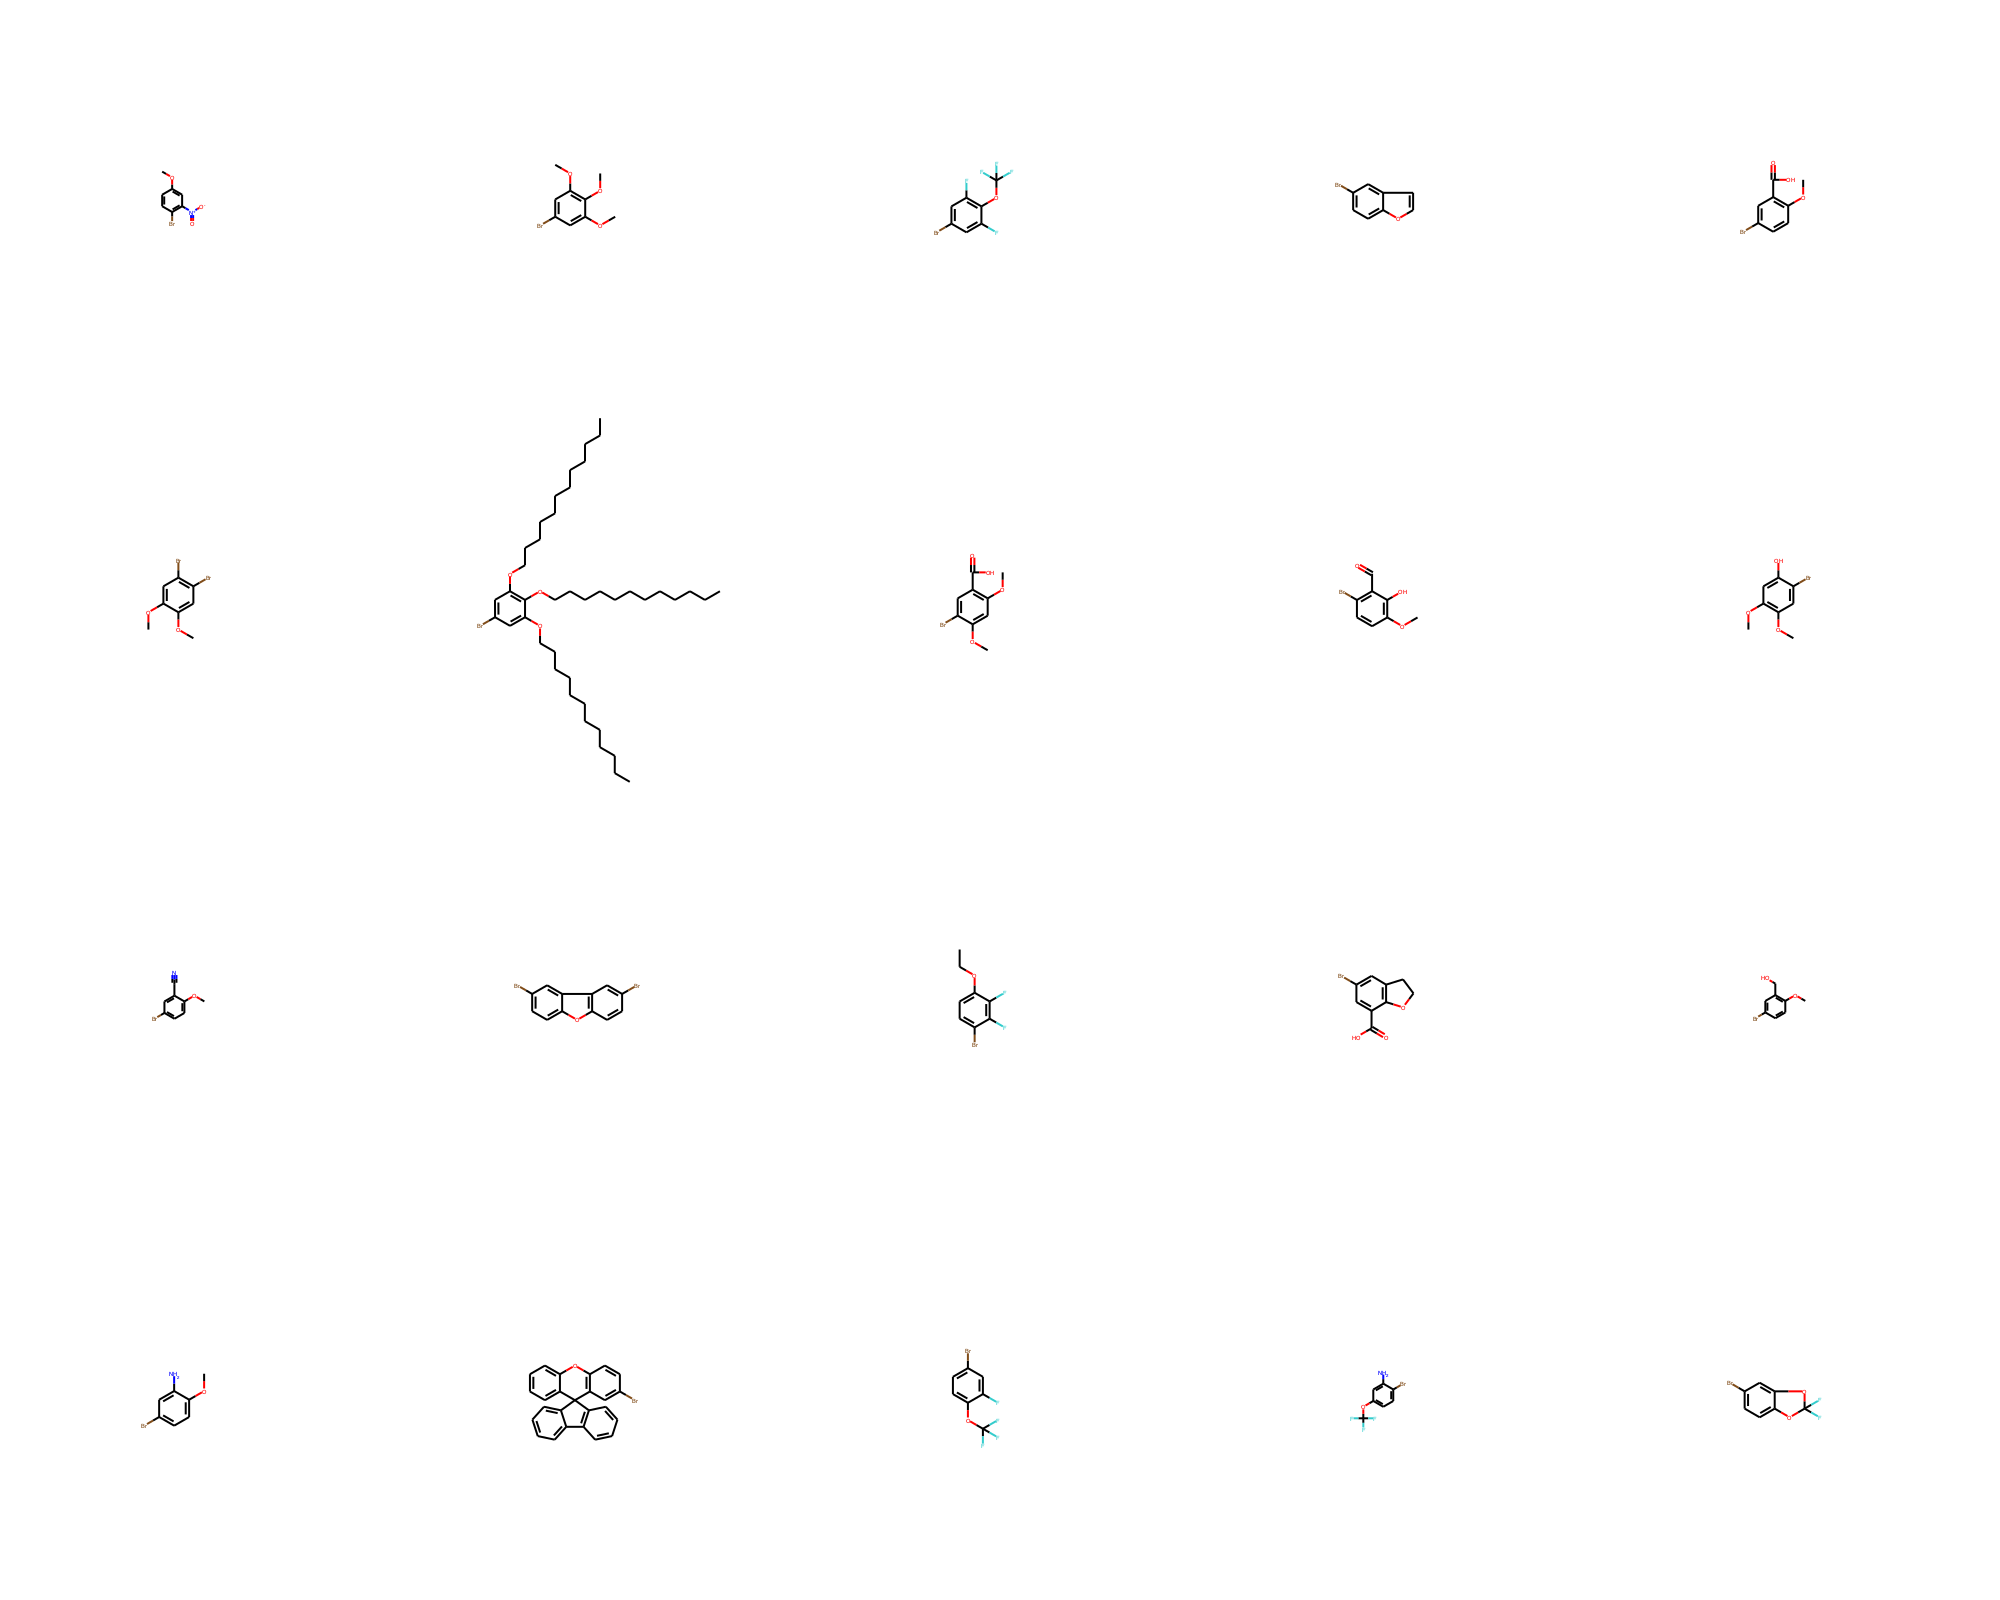

In [55]:
Draw.MolsToGridImage(sub1, subImgSize=(400, 400), molsPerRow=5)

In [57]:
def cross_coupling(mol1, mol2):
    ### mol1: ArBr, mol2: Bpin
    product_smiles = {}
    product_list = []
    compounds = rxn4.RunReactants([mol1, mol2])
    if len(compounds) == 0:
        return product_list
    for compound in compounds:
        sm = Chem.MolToSmiles(compound[0])
        product_smiles[sm] = compound[0]
    ### remove duplicated compound
    for smiles in product_smiles.keys():
        p = Chem.MolFromSmiles(smiles)
        product_list.append(p)
        ### check for do coupling again or not
        if rxn4.IsMoleculeReactant(p):
            p_01 = cross_coupling(p, mol2)
            p_02 = cross_coupling(mol1, p)
            if not p_01 == []:
                product_list.extend(p_01)
            if not p_02 == []:
                product_list.extend(p_02)
    return product_list

def remove_duplicates(mols):
    smiles_dict = {}
    final_mols = []
    for mol in mols:
        sm = Chem.MolToSmiles(mol)
        smiles_dict[sm] = mol
    for smiles in smiles_dict.keys():
        m = Chem.MolFromSmiles(smiles)
        AllChem.Compute2DCoords(m)
        final_mols.append(m)
    return final_mols


In [59]:
# execute coupling
products = []
for i in sub1:
    for j in sub2:
        products.extend(cross_coupling(i, j))

print(len(products))
products = remove_duplicates(products)
print(len(products))

440
440


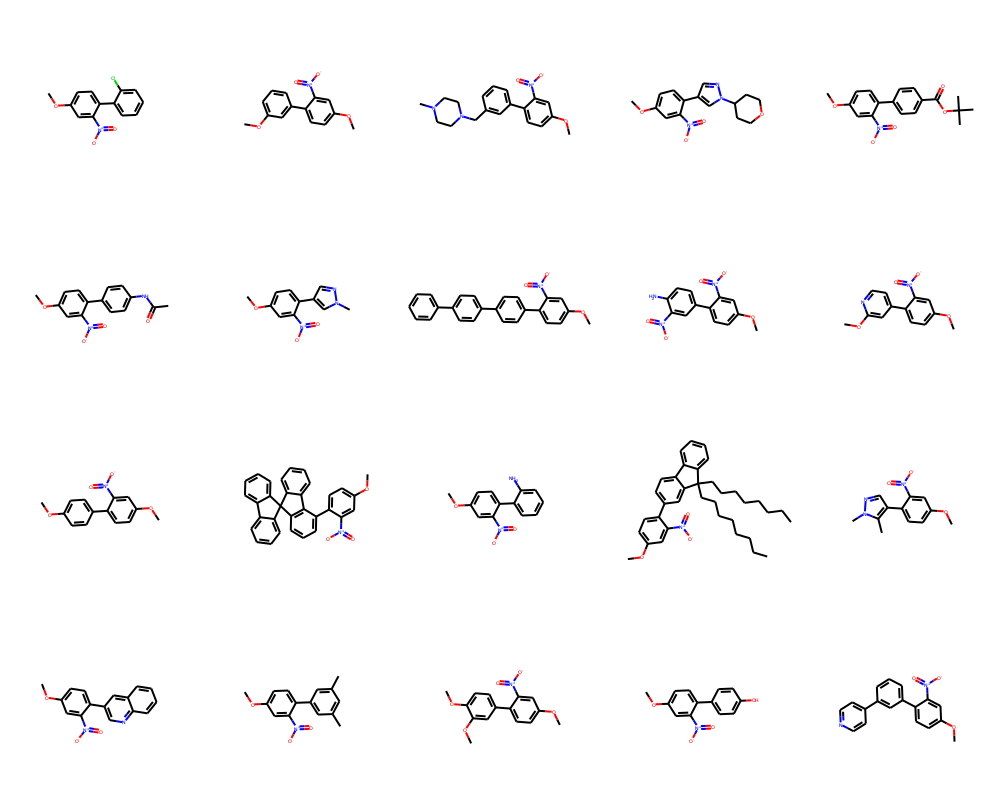

In [62]:
Draw.MolsToGridImage(products[:20], molsPerRow=5)